In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

Data:
Stock prices of NVDA from 26-10-2020 to 23-10-2023 (~3 year) 

In [2]:
df = pd.read_csv("NVDA.csv", index_col="Date", parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-26,134.270004,136.927505,130.384995,131.412506,131.089798,33689600
2020-10-27,133.059998,134.419998,131.914993,133.967499,133.638519,25052000
2020-10-28,131.979996,132.600006,126.089996,126.269997,125.959908,37652000
2020-10-29,128.384995,131.927505,127.500000,130.240005,129.920197,32008000
2020-10-30,128.500000,129.365005,123.000000,125.339996,125.032204,41682000


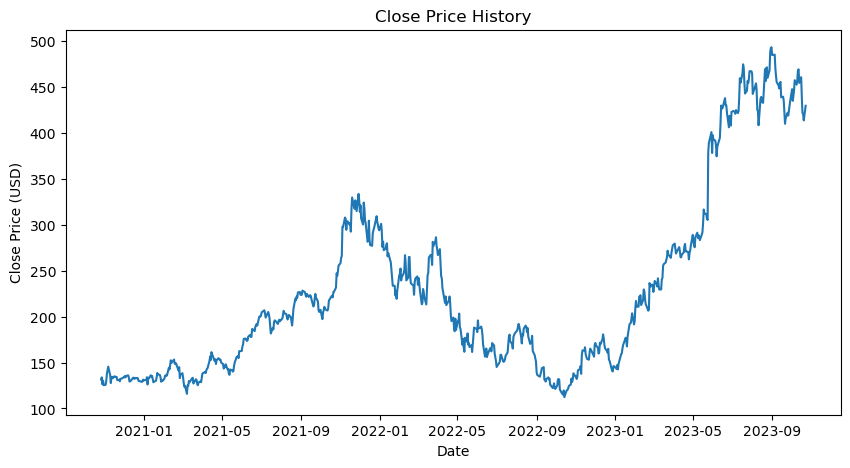

In [3]:
plt.figure(figsize=(10, 5))
plt.title("Close Price History")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")

plt.plot(df["Close"])
plt.show()

In [4]:
df_close = df["Close"]

## ADF Test for stationarity

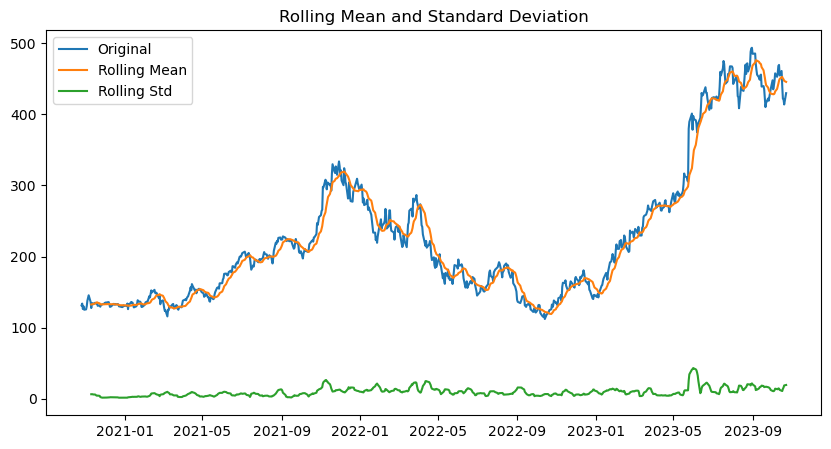

In [5]:
rollmean = df_close.rolling(12).mean()
rollstd = df_close.rolling(12).std()

plt.figure(figsize=(10, 5))
plt.plot(df_close, label='Original')
plt.plot(rollmean, label='Rolling Mean')
plt.plot(rollstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()

In [6]:
adft = adfuller(df_close,autolag='AIC')
output = pd.Series(adft[:4],index=['Test statistic', 'p-value', 'No. lags used','No. observations used'])
for key, values in adft[4].items():
    output['Critical value (%s)'%key] = values
print(output)

Test statistic            -0.364552
p-value                    0.915851
No. lags used              0.000000
No. observations used    752.000000
Critical value (1%)       -3.439076
Critical value (5%)       -2.865391
Critical value (10%)      -2.568821
dtype: float64


Clearly not stationary

So we need to separate the trend and seasonality from the data

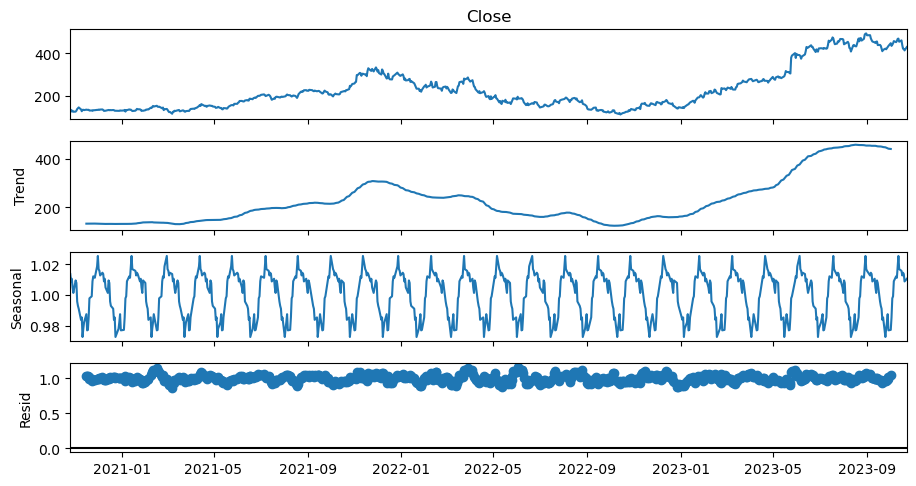

In [7]:
fig = seasonal_decompose(df_close, model="multiplicative", period=30).plot()
fig.set_size_inches(10, 5)

In [8]:
# Eliminate trend by taking log
df_log = np.log(df_close)

In [9]:
# Split to train and test
train_data_len = int(len(df_log) * 0.9)
train_data, test_data = df_log[:train_data_len], df_log[train_data_len:]

# Choosing p, d, q for ARIMA with Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2640.130, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2647.650, Time=0.05 sec


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2645.827, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2645.828, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2647.922, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2643.831, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.475 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  677
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1324.961
Date:                Tue, 24 Oct 2023   AIC                          -2647.922
Time:                        15:28:27   BIC                          -2643.405
Sample:                             0   HQIC                         -2646.173
                                - 677                                         
Covariance Type:                  opg                                         
                 coef  

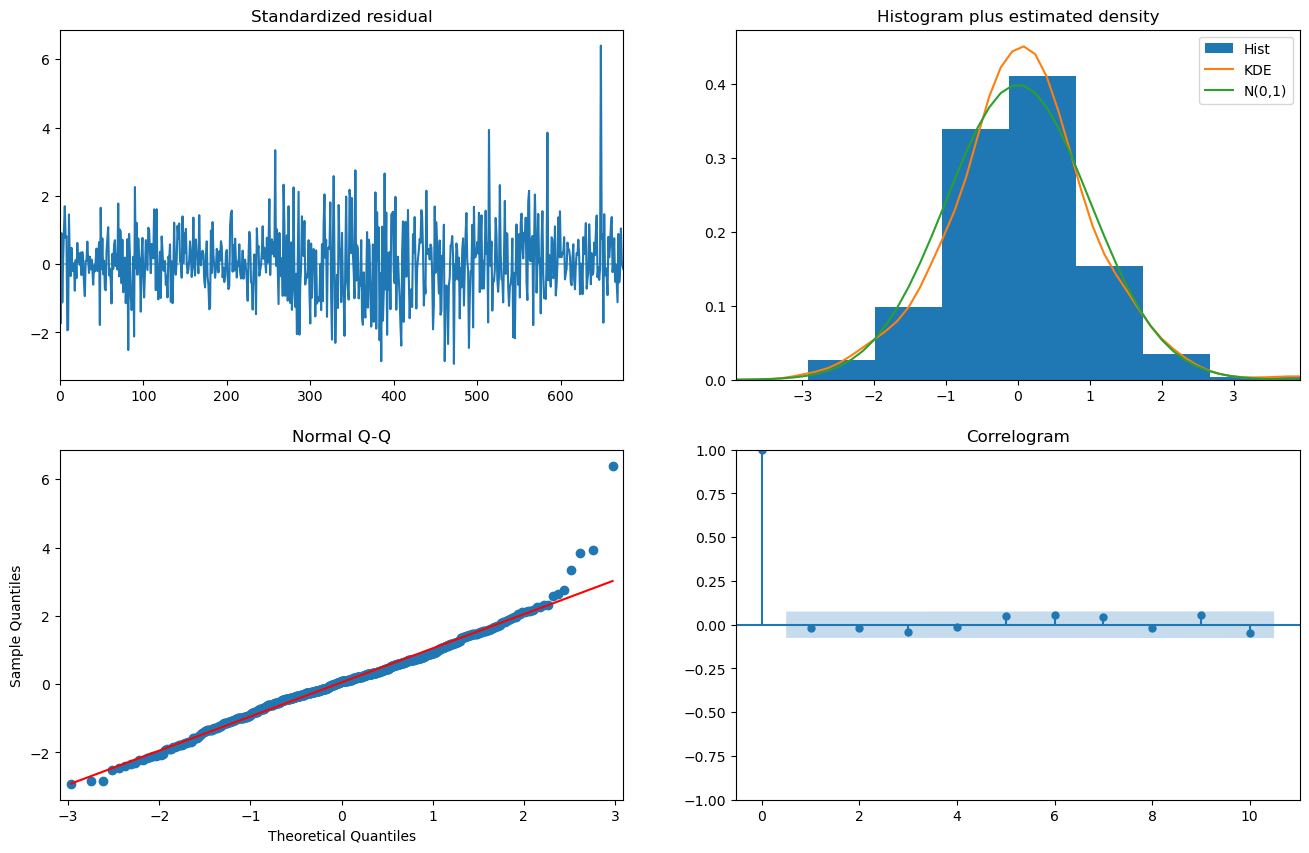

In [10]:
autoARIMA = auto_arima(train_data, trace=True)
print(autoARIMA.summary())
autoARIMA.plot_diagnostics(figsize=(16, 10))
plt.show()

So p, d, q = 0, 1, 0

In [11]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit() 
print(fitted.summary()) 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1324.961
Date:                Tue, 24 Oct 2023   AIC                          -2647.922
Time:                        15:28:28   BIC                          -2643.405
Sample:                             0   HQIC                         -2646.173
                                - 677                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   4.04e-05     28.718      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               242.81
Prob(Q):                              0.67   Pr

/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
fc = fitted.forecast(len(test_data))
fc.index = test_data.index
rmse = np.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
rmse

/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


33.862333074439796

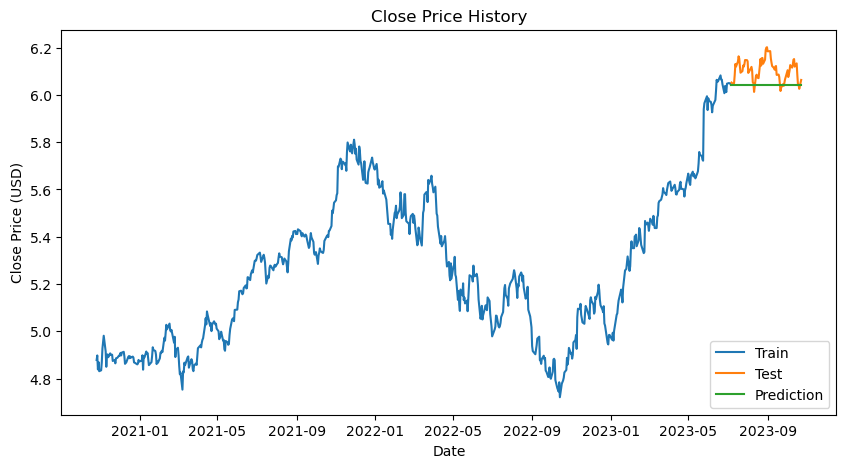

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Close Price History")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")

plt.plot(train_data)
plt.plot(test_data)
plt.plot(fc)
plt.legend(["Train", "Test", "Prediction"], loc="lower right")
plt.show()

# Inference

In [14]:
model = ARIMA(df_log, order=(0, 1, 0))  
fitted = model.fit()  
print(fitted.summary()) 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  753
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1492.243
Date:                Tue, 24 Oct 2023   AIC                          -2982.486
Time:                        15:28:28   BIC                          -2977.863
Sample:                             0   HQIC                         -2980.705
                                - 753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   3.63e-05     30.498      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               283.41
Prob(Q):                              0.68   Pr

/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/base/model

In [15]:
start_date = df.index[-1] + pd.Timedelta(days=1)
end_date = pd.to_datetime("2023-11-7")

days_to_predict = pd.date_range(start_date, end_date, freq="B").shape[0]

fc = fitted.forecast(days_to_predict)
fc.index = pd.date_range(start_date, end_date, freq="B")

fc = np.exp(fc)

/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/users/eleves-a/2022/ha-duy.nguyen/mambaforge/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


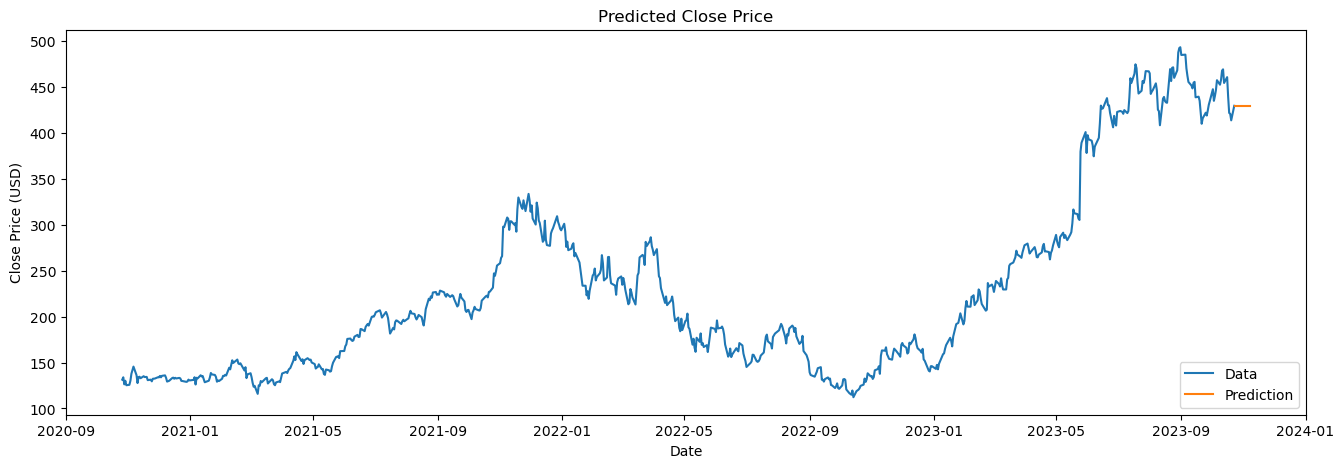

In [16]:
plt.figure(figsize=(16, 5))
plt.title("Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)") 

plt.plot(df_close)
plt.plot(fc)
plt.legend(["Data", "Prediction"], loc="lower right")
plt.show()

In [17]:
days_to_submit = 10
submission = pd.DataFrame({
    "index": range(days_to_submit),
    "Close": fc[-days_to_submit:],
})
submission.to_csv("submission2.csv", index=False)
submission

,index,Close
2023-10-25,0,429.75
2023-10-26,1,429.75
2023-10-27,2,429.75
2023-10-30,3,429.75
2023-10-31,4,429.75
2023-11-01,5,429.75
2023-11-02,6,429.75
2023-11-03,7,429.75
2023-11-06,8,429.75
2023-11-07,9,429.75
